# Movielens dataset preprocessing
### Import

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../')
from experiments.datasets.data_utils.preprocessing_utilities import stat_unique,get_modalities_nb, remove_duplicates, densify,create_q2k, encode_attr, quadruplet_format, parse_data, split_data, save_to_csv,get_metadata, split_data_vertically,rescaling_dict,one_hot_encoding,split_small_data_vertically

import json
import pandas as pd
import numpy as np

### Load and merge dataset

In [5]:
# Specify the path to your .dat file
rating_path = '../1-raw_data/ml-1m/ratings.dat'
movie_path = '../1-raw_data/ml-1m/movies.dat'

df_movie = pd.read_csv(movie_path, delimiter='::',names=["item_id","title","dimension_id"])
df_rating = pd.read_csv(rating_path, delimiter='::', names=["user_id","item_id","correct","Timestamp"]) 
raw_data = pd.merge(df_movie, df_rating, on='item_id', how='inner')
raw_data.head()

/tmp/ipykernel_122830/2046474539.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_movie = pd.read_csv(movie_path, delimiter='::',names=["item_id","title","dimension_id"])
/tmp/ipykernel_122830/2046474539.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_rating = pd.read_csv(rating_path, delimiter='::', names=["user_id","item_id","correct","Timestamp"])


,item_id,title,dimension_id,user_id,correct,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


### Split rows with several dimensions

In [6]:
df_expanded = raw_data.assign(dimension_id=raw_data['dimension_id'].str.split('|')).explode('dimension_id').reset_index(drop=True)
df_expanded.head()

,item_id,title,dimension_id,user_id,correct,Timestamp
0,1,Toy Story (1995),Animation,1,5,978824268
1,1,Toy Story (1995),Children's,1,5,978824268
2,1,Toy Story (1995),Comedy,1,5,978824268
3,1,Toy Story (1995),Animation,6,4,978237008
4,1,Toy Story (1995),Children's,6,4,978237008


### Early stats

In [7]:
print(len(df_expanded))
all_data = df_expanded.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

2101815
2101815


In [8]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 2101815
Number of unique [user_id,item_id]: 1000209
Number of unique user_id: 6040
Number of unique item_id: 3706
Number of unique dimension_id: 18


### Similar dimension grouping

In [9]:
all_data.groupby("item_id")["dimension_id"].nunique().mean()

1.6708041014570967

In [10]:
genres = list(all_data['dimension_id'].unique())
genres_to_idx = {}
idx_to_genres = {}
i=0
for g in genres :
    genres_to_idx[g] =i
    idx_to_genres[i] = g
    i+=1

In [11]:
links = np.zeros((len(genres),len(genres)))
for r in all_data.groupby("item_id")["dimension_id"].unique() :
    for i,g1 in enumerate(r[:-1]) :
        for g2 in r[i+1:] :
            d = links[genres_to_idx[g1],genres_to_idx[g2]]
            links[genres_to_idx[g1],genres_to_idx[g2]] = d+1
            d = links[genres_to_idx[g2],genres_to_idx[g1]]
            links[genres_to_idx[g2],genres_to_idx[g1]] = d+1

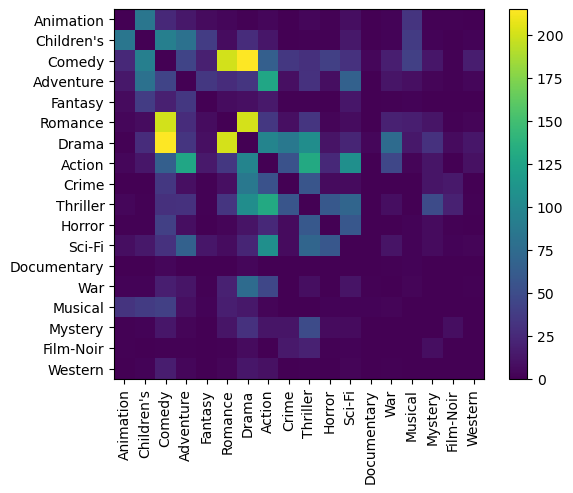

In [12]:
import matplotlib.pyplot as plt
plt.imshow(links)
plt.xticks(np.arange(len(genres)),genres, rotation=90)
plt.yticks(np.arange(len(genres)),genres)
plt.colorbar()

In [13]:
def tarjan_scc(adj_matrix):
    n = len(adj_matrix)
    index = [-1] * n
    lowlink = [0] * n
    on_stack = [False] * n
    stack = []
    sccs = []
    current_index = [0]  # use a list to allow modifications in closure

    def strongconnect(v):
        # Set the depth index for v
        index[v] = current_index[0]
        lowlink[v] = current_index[0]
        current_index[0] += 1
        stack.append(v)
        on_stack[v] = True

        # Consider successors of v
        for w in range(n):
            if adj_matrix[v][w] == 1:  # edge from v to w
                if index[w] == -1:
                    # Successor w has not yet been visited
                    strongconnect(w)
                    lowlink[v] = min(lowlink[v], lowlink[w])
                elif on_stack[w]:
                    # Successor w is on the stack, so it's part of the current SCC
                    lowlink[v] = min(lowlink[v], index[w])

        # If v is a root node, pop the stack and generate an SCC
        if lowlink[v] == index[v]:
            # Start a new strongly connected component
            scc = []
            while True:
                w = stack.pop()
                on_stack[w] = False
                scc.append(idx_to_genres[w])
                if w == v:
                    break
            sccs.append(scc)

    for v in range(n):
        if index[v] == -1:
            strongconnect(v)

    return sccs

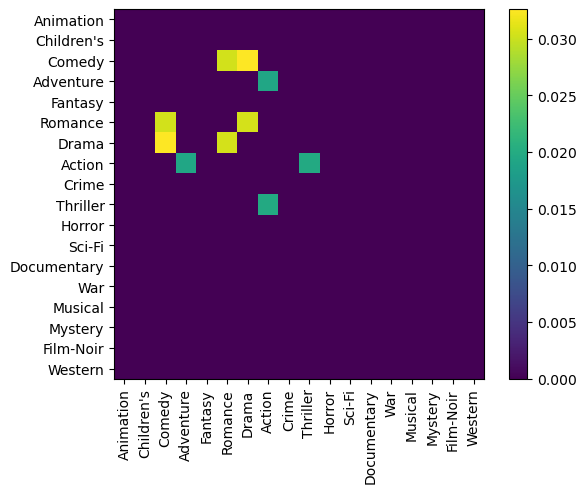

In [14]:
F = links/links.sum()
A = np.where(F>0.017,F,np.zeros_like(F))
import matplotlib.pyplot as plt
plt.imshow(A)
plt.xticks(np.arange(len(genres)),genres, rotation=90)
plt.yticks(np.arange(len(genres)),genres)
plt.colorbar()

In [15]:
sccs = tarjan_scc(np.where(A>0,1,0))
print("Strongly Connected Components:", sccs)


Strongly Connected Components: [['Animation'], ["Children's"], ['Drama', 'Romance', 'Comedy'], ['Thriller', 'Action', 'Adventure'], ['Fantasy'], ['Crime'], ['Horror'], ['Sci-Fi'], ['Documentary'], ['War'], ['Musical'], ['Mystery'], ['Film-Noir'], ['Western']]


In [16]:
dim_transform = {'Drama':'Drama_Romance_Comedy','Romance':'Drama_Romance_Comedy','Comedy':'Drama_Romance_Comedy','Thriller':'Thriller_Action_Adventure','Action':'Thriller_Action_Adventure','Adventure':'Thriller_Action_Adventure'}

In [17]:
less_connected = all_data.copy()
less_connected['dimension_id'] = less_connected['dimension_id'].apply(lambda x : dim_transform.get(x,x))
less_connected.groupby("item_id")["dimension_id"].nunique().mean()

1.4422558014031301

### Clean Nan values

In [18]:
cleaned_data = less_connected.dropna(subset=['user_id','item_id','dimension_id','correct'], axis='index')

### Remove duplicated user and id rows

In [19]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

### Filter Data

In [20]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 : 
    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',50)
    # filter users
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',50)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',50)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 1192 item_id
filter 1781 user_id
filter 2 dimension_id
filter 37 item_id
filter 19 user_id
filter 1 dimension_id
filter 0 item_id
filter 9 user_id
filter 0 dimension_id
filter 1 item_id
filter 0 user_id
filter 0 dimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 1562240
Number of unique [user_id,item_id]: 906431
Number of unique user_id: 4231
Number of unique item_id: 2421
Number of unique dimension_id: 11


### Encoding

In [21]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [22]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [23]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [24]:
q2k, k2q = create_q2k(d_enc_data)

### Rescaling responses

In [25]:
resc_data = d_enc_data
resc_data['correct'] = resc_data['correct'].astype(float)
min_val = resc_data['correct'].min()
max_val = resc_data['correct'].max()
resc_data['correct'] = (resc_data['correct']-min_val)/(max_val-min_val) +1
print(f'min value : {resc_data["correct"].min()}, max value : {resc_data["correct"].max()}')

min value : 1.0, max value : 2.0


### Get final stats and create metadata

In [26]:
stat_unique(resc_data, None)
stat_unique(resc_data, ['user_id', 'item_id'])
stat_unique(resc_data, 'user_id')
stat_unique(resc_data, 'item_id')
stat_unique(resc_data, 'dimension_id')
stat_unique(resc_data, 'correct')

resc_data_dim_grouped_items = resc_data.groupby("dimension_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("user_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

Total length: 1562240
Number of unique [user_id,item_id]: 906431
Number of unique user_id: 4231
Number of unique item_id: 2421
Number of unique dimension_id: 11
Number of unique correct: 5
#questions/category: 62 & 340 &  1670
#users/category: 3776 & 4043 &  4231
#categorys/question: 1 & 2 &  5
#users/question: 50 & 374 &  2731
#questions/users: 50 & 214 &  1832
#categorys/users: 5 & 11 &  11


Text(0.5, 1.0, 'Distribution of Responses')

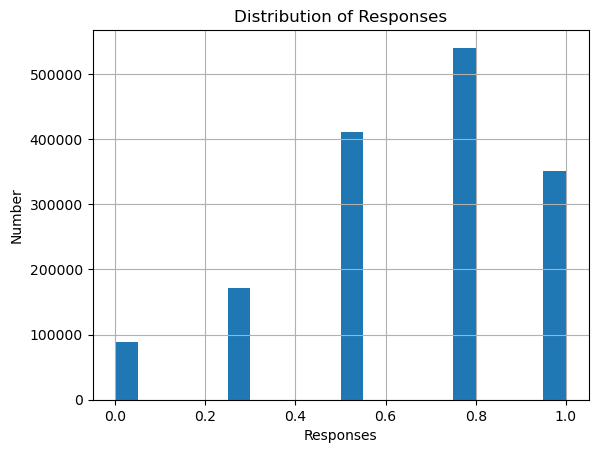

In [27]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(resc_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')


In [28]:
plt.savefig('distribution_movielens.png')

<Figure size 640x480 with 0 Axes>

In [29]:
metadata = get_metadata(resc_data,["user_id", "item_id", "dimension_id"])

## Compute nb of modalities

In [30]:
nb_modalities = get_modalities_nb(resc_data, metadata)

### Save data, concept map, metadata and nb of modalities

In [195]:
# save selected data
resc_data.to_csv('../1-raw_data/movielens_selected_data.csv', index=False)

In [196]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [197]:
# save metadata
with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

In [31]:
# save nb_modalities
import torch
torch.save(nb_modalities,'nb_modalities.pkl')

## parse data

In [198]:
resc_data = pd.read_csv('selected_data.csv')
quadruplet = quadruplet_format(resc_data)

In [199]:
stu_data, ques_data = parse_data(resc_data)

In [200]:
test_size = 0.2
valid_size = 0.2 # proportion over the all dataset
least_test_length=100

## Horizontal split

In [35]:
train_data, valid_data, test_data = split_data(quadruplet, stu_data, test_prop=test_size, valid_prop=valid_size, least_test_length=least_test_length) 

In [36]:
print(f'train records length: {len(train_data)}')
print(f'test records length: {len(test_data)}')
print(f'valid records length: {len(valid_data)}')
print(f'all records length: {len(train_data)+len(valid_data)+len(test_data)}')

## save row data

In [37]:
save_to_csv(train_data, '../2-preprocessed_data/movielens_train_quadruples.csv')
save_to_csv(valid_data, '../2-preprocessed_data/movielens_valid_quadruples.csv')
save_to_csv(test_data, '../2-preprocessed_data/movielens_test_quadruples.csv')

## vertical split

In [201]:
train_data, valid_data, test_data = split_data_vertically(quadruplet, test_prop=test_size,valid_prop=valid_size,folds_nb=5)

In [202]:
for i_fold, train_fold in enumerate(train_data):
    save_to_csv(train_data[i_fold], f'../2-preprocessed_data/movielens_train_quadruples_vert_{i_fold}.csv')
    save_to_csv(valid_data[i_fold], f'../2-preprocessed_data/movielens_valid_quadruples_vert_{i_fold}.csv')
    save_to_csv(test_data[i_fold], f'../2-preprocessed_data/movielens_test_quadruples_vert_{i_fold}.csv')

#### Toy dataset generation

In [203]:
train_data_small, valid_data_small, test_data_small = split_small_data_vertically(quadruplet, test_prop=0.95,
                                                                                  valid_prop=0.025)

save_to_csv(train_data_small, f'../2-preprocessed_data/movielens_small_train_quadruples_vert_{0}.csv')
save_to_csv(valid_data_small, f'../2-preprocessed_data/movielens_small_valid_quadruples_vert_{0}.csv')
save_to_csv(test_data_small, f'../2-preprocessed_data/movielens_small_test_quadruples_vert_{0}.csv')

In [35]:
len(train_data_small)

45422

### one hot encoding

In [ ]:
train = pd.read_csv("../2-preprocessed_data/movielens_train_quadruples.csv").astype({'student_id':int, 'item_id':int, "correct":float})
duplicated_train = one_hot_encoding(train,response_range_dict)
duplicated_train.to_csv('../2-preprocessed_data/movielens_train_quadruples_ohe.csv', index=False)

In [ ]:
valid = pd.read_csv("../2-preprocessed_data/movielens_valid_quadruples.csv").astype({'student_id':int, 'item_id':int, "correct":float})
duplicated_valid = one_hot_encoding(valid,response_range_dict)
duplicated_valid.to_csv('../2-preprocessed_data/movielens_valid_quadruples_ohe.csv', index=False)

In [52]:
test = pd.read_csv("../2-preprocessed_data/movielens_test_quadruples.csv")
duplicated_test = one_hot_encoding(test,response_range_dict)
duplicated_test.to_csv('../2-preprocessed_data/movielens_test_quadruples_ohe.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

for i in range(5) : 
    train = pd.read_csv("../2-preprocessed_data/movielens_train_quadruples_vert_"+str(i)+".csv").astype({'student_id':int, 'item_id':int, "correct":float})
    duplicated_train = one_hot_encoding(train,response_range_dict)
    duplicated_train.to_csv('train_quadruples_vert_ohe_'+str(i)+'.csv', index=False)
    
    valid = pd.read_csv("../2-preprocessed_data/movielens_valid_quadruples_vert_"+str(i)+".csv").astype({'student_id':int, 'item_id':int, "correct":float})
    duplicated_valid = one_hot_encoding(valid,response_range_dict)
    duplicated_valid.to_csv('valid_quadruples_vert_ohe_'+str(i)+'.csv', index=False)
    
    test = pd.read_csv("../2-preprocessed_data/movielens_test_quadruples_vert_"+str(i)+".csv").astype({'student_id':int, 'item_id':int, "correct":float})
    duplicated_test = one_hot_encoding(test,response_range_dict)
    duplicated_test.to_csv('../2-preprocessed_data/movielens_test_quadruples_vert_ohe_'+str(i)+'.csv', index=False)